<a href="https://colab.research.google.com/github/Dhanusree007/Nsl_kdd_dataset_project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.cluster import KMeans
import tensorflow as tf
import seaborn as sns

from google.colab import files
data=files.upload()

Saving nsl_kdd_dataset.csv to nsl_kdd_dataset.csv


Saving nsl_kdd_dataset.csv to nsl_kdd_dataset (3).csv


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8023465703971119
Precision: 0.8049001814882033
Recall: 0.9955106621773289
F1: 0.8901154039136979
ROC-AUC: 0.47382685017093623


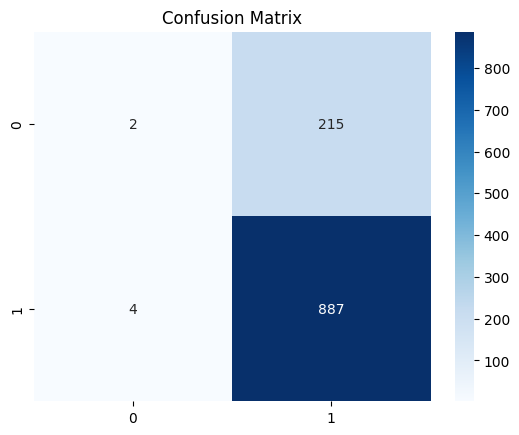

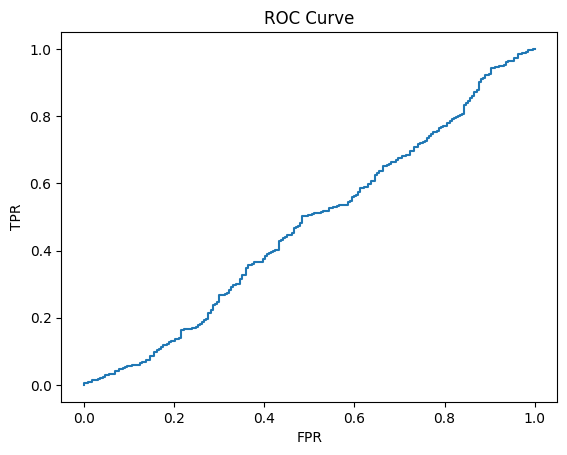

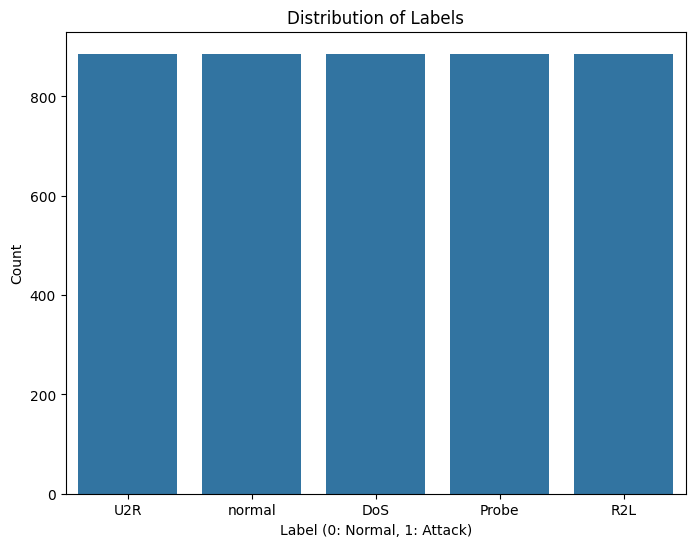

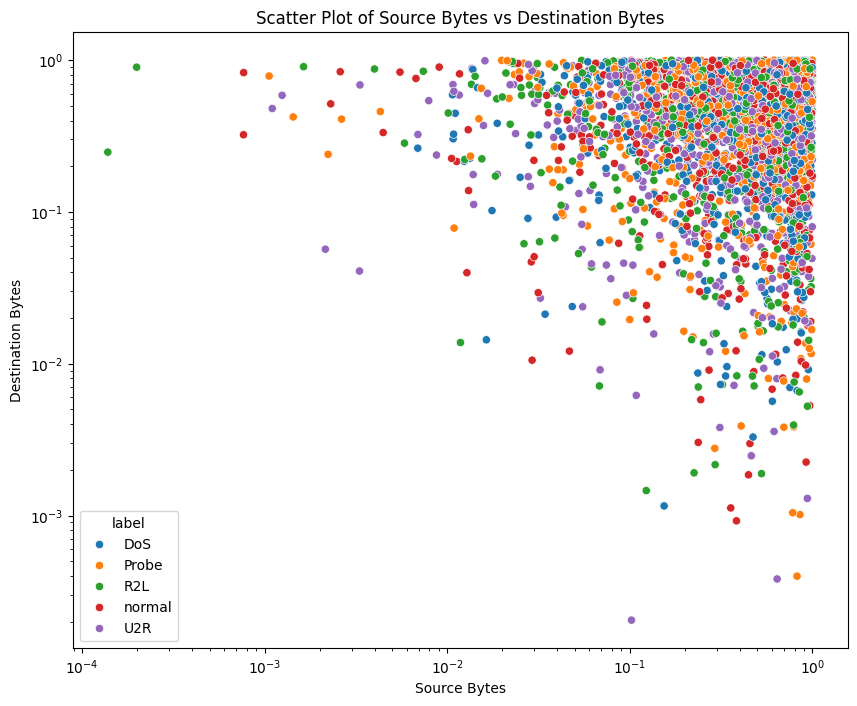

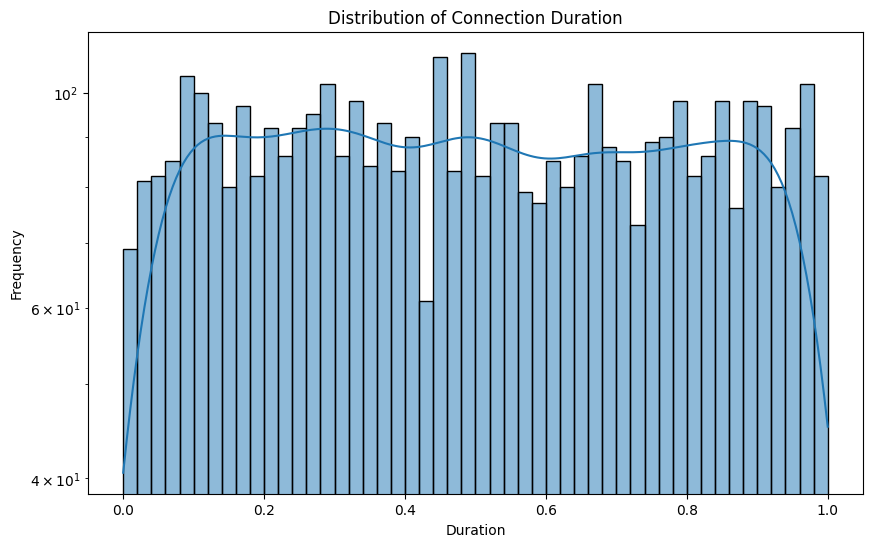

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.cluster import KMeans
import tensorflow as tf
import seaborn as sns

from google.colab import files
data=files.upload()

# Define column names for KDD dataset (assuming standard KDD test structure)
# This list has 41 features + 1 label. Adjust if kdd_test.csv has different columns.
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]

df = pd.read_csv("nsl_kdd_dataset.csv", names=column_names, skiprows=1) # Skip the header row
df = df.drop_duplicates()

# Convert all feature columns to numeric, coercing errors to NaN
for col in column_names[:-1]: # All columns except 'label' should be numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle any NaNs that might have been introduced by coercion (e.g., fill with median)
for col in df.columns[:-1]: # Apply to all feature columns
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Separate features (X) and target (y)
X = df.drop("label", axis=1) # Drop the actual label from features
y = df["label"] # Use the 'label' column as target

# Convert the multi-class 'label' to binary (0 for 'normal', 1 for attacks)
# This aligns with the binary classification model setup.
y = y.apply(lambda x: 0 if x == 'normal' else 1)

# Identify categorical features in X
# 'protocol_type', 'service', 'flag' are common categorical features
categorical_features = ['protocol_type', 'service', 'flag']

# Apply LabelEncoder to categorical features in X
for col in categorical_features:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Now all columns in X should be numeric. Scale them.
sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

model.save("tf_model.keras")

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto') # Added n_init='auto' for KMeans to suppress warning
df["cluster"] = kmeans.fit_predict(X)

# Bar graph for label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=df['label'])
plt.title('Distribution of Labels')
plt.xlabel('Label (0: Normal, 1: Attack)')
plt.ylabel('Count')
plt.show()

# Scatter plot of Source Bytes vs Destination Bytes
plt.figure(figsize=(10, 8))
sns.scatterplot(x='src_bytes', y='dst_bytes', hue='label', data=df.sample(n=min(5000,len(df)), random_state=42))
plt.title('Scatter Plot of Source Bytes vs Destination Bytes')
plt.xlabel('Source Bytes')
plt.ylabel('Destination Bytes')
plt.xscale('log') # Use log scale as byte sizes can vary widely
plt.yscale('log') # Use log scale as byte sizes can vary widely
plt.show()

# Histogram for 'duration' column
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=50, kde=True)
plt.title('Distribution of Connection Duration')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.yscale('log') # Use log scale for y-axis to better visualize skewed distributions
plt.show()